# Target Transformation Experiment
This notebook investigates whether transforming the target variable (Scores) can improve model performance.
We suspect the distribution of user scores is not normal (Gaussian), which can hinder regression models.
We will test:
1. **Baseline**: RidgeCV on raw scores.
2. **QuantileTransformer**: Forcing scores to a Normal distribution.
3. **PowerTransformer**: Using Yeo-Johnson transform to make scores more Gaussian-like.


Project root set to: c:\ComfyUI\trainer
Loading filtered data from cache: C:\ComfyUI\trainer\training\output\filtered_data_cache.npz
Data ready (cached). Filtered shape: (6105, 2186)
Data Shape: X=(6105, 2186), y=(6105,)


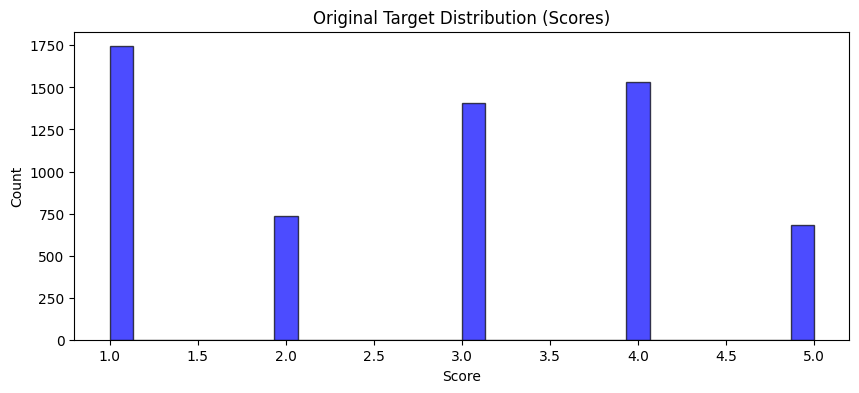

In [3]:
# 1. Setup Data and Imports
from pathlib import Path
import sys
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, QuantileTransformer, PowerTransformer
from sklearn.compose import TransformedTargetRegressor

# Set project root
p = Path.cwd().parent
if str(p) not in sys.path:
    sys.path.insert(0, str(p))
print("Project root set to:", p)

import shared.config
from shared.config import config
from training.helpers import resolve_path
from training.data_utils import get_filtered_data

# Load Data
vectors_path = resolve_path(config["vectors_file"])
scores_path = resolve_path(config["scores_file"])
X, y, kept_indices = get_filtered_data(vectors_path, scores_path)

print(f"Data Shape: X={X.shape}, y={y.shape}")

# Visualize Target Distribution
plt.figure(figsize=(10, 4))
plt.hist(y, bins=30, alpha=0.7, color='blue', edgecolor='black')
plt.title("Original Target Distribution (Scores)")
plt.xlabel("Score")
plt.ylabel("Count")
plt.show()

In [7]:
# 2. Define Evaluation Function and Load Top Config
import lightgbm as lgb
import json

# Load Top Config
# Strict config access: direct indexing
try:
    training_cfg = config["training"]
    # Access 'top' directly if it exists, assume dict interface for sub-objects
    if "top" in training_cfg:
        top_config = training_cfg["top"]
    else:
        top_config = None
except KeyError:
    top_config = None

if top_config:
    print("Loaded Top LightGBM Config:")
    # Filter out metadata keys AND early_stopping_rounds
    # early_stopping_rounds requires an eval_set during fit(), which cross_val_score doesn't provide easily.
    # We will rely on n_estimators which is already tuned.
    ignore_keys = ['best_score', 'training_time', 'early_stopping_rounds']
    clean_params = {k: v for k, v in top_config.items() if k not in ignore_keys}
    
    # Handle device
    device_setting = "cpu"
    if "device" in training_cfg:
        device_setting = training_cfg["device"]
        if device_setting == "cuda":
            device_setting = "gpu"
            
    clean_params['device'] = device_setting
    clean_params['verbosity'] = -1
    print(clean_params)
else:
    print("Warning: No 'top' config found in training_config.json. Using defaults.")
    clean_params = {"n_estimators": 500, "learning_rate": 0.05, "verbosity": -1}

def evaluate_model(model, name="Model"):
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X, y, cv=kf, scoring='r2')
    mean_score = np.mean(scores)
    std_score = np.std(scores)
    print(f"{name} R2: {mean_score:.6f} (+/- {std_score:.6f})")
    return mean_score

results = {}

Loaded Top LightGBM Config:
{'learning_rate': 0.44550000000000006, 'n_estimators': 675, 'num_leaves': 372, 'max_depth': 1, 'min_child_samples': 90, 'reg_alpha': 8.1, 'reg_lambda': 4.099784786849741, 'subsample': 0.11979000000000002, 'colsample_bytree': 0.1, 'min_split_gain': 0.5, 'device': 'gpu', 'verbosity': -1}


In [8]:
# 3. Baseline: No Transformation
# Using LightGBM with Top Config
model_base = lgb.LGBMRegressor(**clean_params)
results['Baseline'] = evaluate_model(model_base, "Baseline (LightGBM)")


c:\ComfyUI\trainer\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\ComfyUI\trainer\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\ComfyUI\trainer\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\ComfyUI\trainer\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Baseline (LightGBM) R2: 0.382628 (+/- 0.014455)


c:\ComfyUI\trainer\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [9]:
# 4. Experiment: Quantile Transformation (Normal Distribution)
# Forces the target distribution to be strictly Gaussian
regressor = lgb.LGBMRegressor(**clean_params)
model_quantile = TransformedTargetRegressor(
    regressor=regressor, 
    transformer=QuantileTransformer(output_distribution='normal', n_quantiles=min(len(y), 1000), random_state=42)
)
results['Quantile (Normal)'] = evaluate_model(model_quantile, "QuantileTransformer")

# 5. Experiment: Power Transformation (Yeo-Johnson)
# Tries to stabilize variance and make it more Gaussian-like preserving some original structure
# Re-instantiate regressor to be safe
regressor_power = lgb.LGBMRegressor(**clean_params)
model_power = TransformedTargetRegressor(
    regressor=regressor_power, 
    transformer=PowerTransformer(method='yeo-johnson')
)
results['Power (Yeo-Johnson)'] = evaluate_model(model_power, "PowerTransformer")


c:\ComfyUI\trainer\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\ComfyUI\trainer\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\ComfyUI\trainer\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\ComfyUI\trainer\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\ComfyUI\trainer\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


QuantileTransformer R2: -0.213518 (+/- 0.027015)


c:\ComfyUI\trainer\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\ComfyUI\trainer\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\ComfyUI\trainer\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\ComfyUI\trainer\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


PowerTransformer R2: 0.386239 (+/- 0.011379)


c:\ComfyUI\trainer\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [ ]:
# 4. Experiment: Quantile Transformation (Normal Distribution)
# Forces the target distribution to be strictly Gaussian
regressor = make_pipeline(StandardScaler(), RidgeCV(alphas=[0.1, 1.0, 10.0]))
model_quantile = TransformedTargetRegressor(
    regressor=regressor, 
    transformer=QuantileTransformer(output_distribution='normal', n_quantiles=min(len(y), 1000), random_state=42)
)
results['Quantile (Normal)'] = evaluate_model(model_quantile, "QuantileTransformer")

# 5. Experiment: Power Transformation (Yeo-Johnson)
# Tries to stabilize variance and make it more Gaussian-like preserving some original structure
model_power = TransformedTargetRegressor(
    regressor=regressor, 
    transformer=PowerTransformer(method='yeo-johnson')
)
results['Power (Yeo-Johnson)'] = evaluate_model(model_power, "PowerTransformer")


QuantileTransformer R2: -0.284443 (+/- 0.058088)
PowerTransformer R2: 0.292042 (+/- 0.022809)


In [10]:
# 6. Comparison
print("\n--- Summary ---")
best_score = -float('inf')
best_method = ""
for name, score in results.items():
    print(f"{name}: {score:.6f}")
    if score > best_score:
        best_score = score
        best_method = name

baseline = results['Baseline']
improvement = best_score - baseline
print(f"\nBest Method: {best_method}")
print(f"Improvement over Baseline: {improvement:.6f}")



--- Summary ---
Baseline: 0.382628
Quantile (Normal): -0.213518
Power (Yeo-Johnson): 0.386239

Best Method: Power (Yeo-Johnson)
Improvement over Baseline: 0.003610
